In [1]:
import sqlite3
import pandas as pd
from pathlib import Path

# Point this to your repo root (or just hardcode the absolute path)
REPO_ROOT = Path(r"E:\Users\Ale\Documents\OpenSesameInterview\openpoke")
DB_PATH = REPO_ROOT / "server" / "data" / "telemetry" / "llm_usage.sqlite"

conn = sqlite3.connect(DB_PATH)

# Show tables
tables = pd.read_sql_query(
    "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;",
    conn
)
display(tables)

,name
0,llm_usage
1,sqlite_sequence


In [2]:
# Print the last 200 rows (most recent first)
df = pd.read_sql_query(
    """
    SELECT *
    FROM llm_usage
    ORDER BY ts_utc
    LIMIT 200;
    """,
    conn
)

display(df)

,id,ts_utc,trace_id,root_source,component,agent_name,purpose,span_id,parent_span_id,model,duration_ms,status,http_status,prompt_tokens,completion_tokens,total_tokens,cost,error
0,1,2026-01-17T17:09:09.790136+00:00,user_request_b85a237d7133,user_request,interaction_agent,None,interaction_agent.query_decomposition,9540481325744f3a,None,anthropic/claude-sonnet-4,734,ok,200,847,6,853,0.002631,None
1,2,2026-01-17T17:09:11.523805+00:00,user_request_b85a237d7133,user_request,interaction_agent,None,interaction_agent.loop,4d4f3ec4ff4f4fea,9540481325744f3a,anthropic/claude-sonnet-4,1563,ok,200,11686,8,11694,0.035178,None
2,3,2026-01-17T17:25:02.715084+00:00,user_request_23e67a550dc3,user_request,interaction_agent,None,interaction_agent.query_decomposition,37f9e184bf884969,None,anthropic/claude-sonnet-4,1672,ok,200,899,19,918,0.002982,None
3,4,2026-01-17T17:25:05.291476+00:00,user_request_23e67a550dc3,user_request,interaction_agent,None,interaction_agent.loop,285d33de9f374933,37f9e184bf884969,anthropic/claude-sonnet-4,2422,ok,200,11784,67,11851,0.036357,None
4,5,2026-01-17T17:25:08.627352+00:00,user_request_23e67a550dc3,user_request,interaction_agent,None,interaction_agent.loop,3743bbc4653d441c,285d33de9f374933,anthropic/claude-sonnet-4,3327,ok,200,11911,118,12029,0.037503,None
5,6,2026-01-17T17:25:10.137215+00:00,user_request_23e67a550dc3,user_request,interaction_agent,None,interaction_agent.loop,c467dd71511443fa,3743bbc4653d441c,anthropic/claude-sonnet-4,1500,ok,200,12147,2,12149,0.036471,None
6,7,2026-01-17T17:25:10.734009+00:00,user_request_23e67a550dc3,user_request,execution_agent,Alessandro Email Search,execution_agent.loop,542cc77cba664c63,3743bbc4653d441c,anthropic/claude-sonnet-4,2093,ok,200,4218,99,4317,0.014139,None
7,8,2026-01-17T17:25:12.779763+00:00,user_request_23e67a550dc3,user_request,execution_agent,Alessandro Email Search,execution_agent.loop,62295fad30cd4f5e,542cc77cba664c63,anthropic/claude-sonnet-4,2047,ok,200,4387,78,4465,0.014331,None
8,9,2026-01-17T17:25:15.150001+00:00,user_request_23e67a550dc3,user_request,execution_agent,Alessandro Email Search,execution_agent.metadata.generate_description,197681fdc47f435b,3743bbc4653d441c,anthropic/claude-sonnet-4,2375,ok,200,377,55,432,0.001956,None
9,10,2026-01-17T17:25:18.161434+00:00,user_request_23e67a550dc3,user_request,interaction_agent,None,interaction_agent.post_exec,0c55abc73cf04248,197681fdc47f435b,anthropic/claude-sonnet-4,3000,ok,200,11819,83,11902,0.036702,None


# Example analyses

### How much is each entry point that causes an llm call costing?

In [3]:
df = pd.read_sql_query(
    """
    SELECT
      root_source,
      COUNT(DISTINCT trace_id) AS events,
      ROUND(SUM(COALESCE(cost, 0)), 6) AS total_cost,
      ROUND(SUM(COALESCE(cost, 0)) / NULLIF(COUNT(DISTINCT trace_id), 0), 6) AS avg_cost_per_event,
      SUM(COALESCE(total_tokens, 0)) AS total_tokens
    FROM llm_usage
    WHERE trace_id IS NOT NULL
    GROUP BY root_source
    ORDER BY total_cost DESC;
    """,
    conn
)

display(df)

,root_source,events,total_cost,avg_cost_per_event,total_tokens
0,user_request,5,0.988020,0.197604,318044
1,trigger,2,0.203379,0.101690,65401
2,email_monitor,1,0.084255,0.084255,27081
3,summarizer,1,0.032385,0.032385,8651


### On average, how expensive is a single user request end-to-end?

In [4]:
df = pd.read_sql_query(
    """
    SELECT
      COUNT(DISTINCT trace_id) AS user_requests,
      ROUND(SUM(COALESCE(cost, 0)), 6) AS total_cost,
      ROUND(SUM(COALESCE(cost, 0)) / NULLIF(COUNT(DISTINCT trace_id), 0), 6) AS avg_cost_per_user_request
    FROM llm_usage
    WHERE root_source = 'user_request'
      AND trace_id IS NOT NULL;
    """,
    conn
)

display(df)

,user_requests,total_cost,avg_cost_per_user_request
0,5,0.98802,0.197604


### Within this one request (triggered an email search), how does cost break down?

In [5]:
df = pd.read_sql_query(
    """
SELECT
      purpose,
      COUNT(*) AS calls,
      ROUND(SUM(COALESCE(cost, 0)), 6) AS total_cost,
      SUM(COALESCE(total_tokens, 0)) AS total_tokens
    FROM llm_usage
    WHERE trace_id = :trace_id
    GROUP BY purpose
    ORDER BY total_cost DESC;
    """,
    conn,
    params={"trace_id": "user_request_82ff98f3ec4a"}
)

display(df)

,purpose,calls,total_cost,total_tokens
0,interaction_agent.loop,3,0.112512,36740
1,interaction_agent.post_exec,1,0.038280,12304
2,execution_agent.loop,2,0.037857,11367
3,tool.task_email_search,2,0.021660,5912
4,interaction_agent.query_decomposition,1,0.003060,928
5,execution_agent.metadata.generate_description,1,0.002118,494


### Visualize dependency structure of a single trace ID call flow

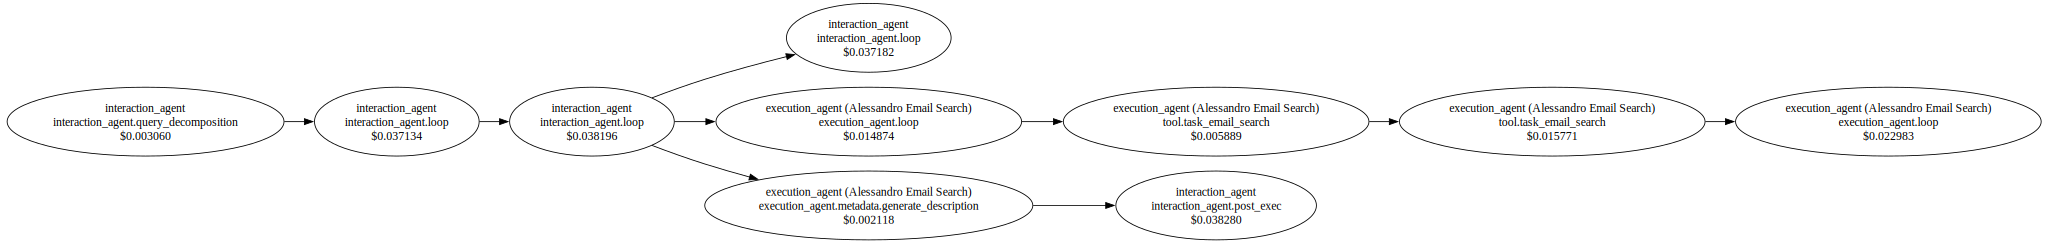

In [6]:
df = pd.read_sql_query(
    """
    SELECT ts_utc, component, agent_name, purpose, span_id, parent_span_id, cost
    FROM llm_usage
    WHERE trace_id = "user_request_82ff98f3ec4a"
    ORDER BY ts_utc ASC
    """,
    conn,
)

### NOTE: You need to have graphviz installed on your system for this to work, not just in your python environment.
from graphviz import Digraph

dot = Digraph("trace", graph_attr={"rankdir":"LR"})

for _, r in df.iterrows():
    who = r["component"] + (f" ({r['agent_name']})" if r["agent_name"] else "")
    cost = 0 if r["cost"] is None else float(r["cost"])
    dot.node(str(r["span_id"]), f"{who}\n{r['purpose']}\n${cost:.6f}")

for _, r in df.iterrows():
    if r["parent_span_id"]:
        dot.edge(str(r["parent_span_id"]), str(r["span_id"]))

display(dot)

In [7]:
conn.close()